# Particle Filter (PF) for Nonlinear Filtering
## Author
- **Name**: Azimov Sherkhon Azizkhon Ugli
- **Email**: sherkhonazim@gmail.com
- **GitHub**: @AzimovSherkhon
Method: PF (SIR) \
Model: The stochastic double well model \
Parameters:\
κ=0.5 (Low Noise Strength),\
M=100 (Number of Particles),\
t_obs = 2 (Observation Frequency), \
num_runs = 50 (To calculate the mean RME and standard deviation (SD) of RME across all runs)

In [1]:
import numpy as np
observations = np.load("Obs_doublewell2_k_0.5.npy")
observation_times = np.load("Obs_time_doublewell2_k_0.5.npy")
mcmc_initial = np.load("samples100.npy")
fdm_solutions = np.load("FDM_0-50_0.5_2.npy")
time_step = 0.01
time_coords = np.linspace(0, time_step * fdm_solutions.shape[1], fdm_solutions.shape[1])
num_points = 1024
domain_length = 2
x_coords = np.linspace(-domain_length, domain_length, num_points)
spatial_step = x_coords[1] - x_coords[0]
fdm_means = np.sum(x_coords[:, None] * fdm_solutions * spatial_step, axis=0)

In [2]:
# Necessary functions
def drift(state):
    return 4 * state - 4 * state**3

def simulate_sde(noise_strength, final_time, time_step, initial_state):
    steps = int(final_time / time_step)
    trajectory = np.zeros(steps)
    trajectory[0] = initial_state
    noise = np.random.normal(0, np.sqrt(time_step), size=steps)
    for i in range(1, steps):
        trajectory[i] = trajectory[i-1] + drift(trajectory[i-1]) * time_step + noise_strength * noise[i-1]
    return trajectory

def initialize_particles(num_particles):
    particles = np.random.normal(0, 0.4, size=num_particles)
    weights = np.ones(num_particles) / num_particles
    return particles, weights

def predict(particles, noise_strength, time_step):
    noise = np.random.normal(0, np.sqrt(time_step), size=len(particles))
    return particles + drift(particles) * time_step + noise_strength * noise

def update_weights(particles, observation, obs_noise_std, weights):
    likelihoods = np.exp(-0.5 * ((observation - particles) / obs_noise_std)**2)
    weights *= likelihoods
    weight_sum = np.sum(weights)
    weights /= weight_sum
    return weights

def resample(particles, weights):
    if not np.any(np.isnan(weights)):
        indices = np.random.choice(range(len(weights)), size=len(weights), p=weights)
        particles = particles[indices]
    return particles

def estimate_state(particles):
    return np.mean(particles)

In [3]:
final_time = 50
initial_state = 0.0
noise_strength = 0.5
num_particles = 100
total_steps = int(final_time / time_step)
obs_frequency = 200
obs_noise_std = 0.2
num_runs = 50

rme_stats = []
for run in range(num_runs):
    particles = mcmc_initial.copy()
    weights = np.ones(num_particles) / num_particles
    positions = np.zeros((total_steps, num_particles))
    positions[0] = particles
    means = np.zeros(total_steps)
    stds = np.zeros(total_steps)
    rme_values = []

    for t in range(1, total_steps):
        particles = predict(particles, noise_strength, time_step)
        if t % obs_frequency == 0:
            obs = observations[t // obs_frequency]
            weights = update_weights(particles, obs, obs_noise_std, weights)
            particles = resample(particles, weights)
            weights.fill(1.0 / num_particles)
        means[t] = estimate_state(particles)
        stds[t] = np.std(particles)
        positions[t] = particles
        rme_values.append(np.abs(means[t] - fdm_means[t]))

    rme_stats.append((np.mean(rme_values), np.std(rme_values)))

mean_rme = np.mean([stat[0] for stat in rme_stats])
std_rme = np.std([stat[0] for stat in rme_stats])

In [4]:
print(f"Mean RME across all runs: {mean_rme:.4f}")
print(f"Standard Deviation of RME across all runs: {std_rme:.4f}")

Mean RME across all runs: 0.2207
Standard Deviation of RME across all runs: 0.1763


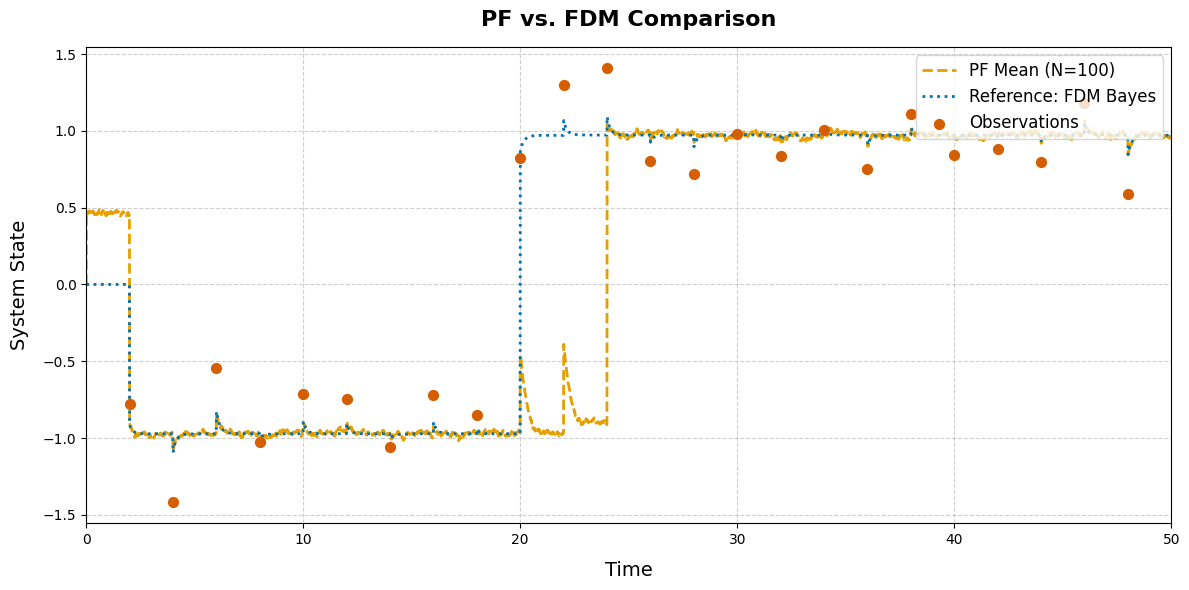

In [5]:
import matplotlib.pyplot as plt
import numpy as np
time_step = 0.01
time_coords = np.linspace(0, time_step * fdm_solutions.shape[1], fdm_solutions.shape[1])
plt.figure(figsize=(12, 6))
plt.plot(time_coords, means, label="PF Mean (N=100)", color="#E69F00", linestyle="--", linewidth=2)  # Orange
plt.plot(time_coords, fdm_means, label="Reference: FDM Bayes", color="#0072B2", linestyle=":", linewidth=2)   # Blue
plt.scatter(observation_times[1:50], observations[1:50], label="Observations", color="#D55E00", s=50, zorder=2)  # Vermilion

plt.xlabel("Time", fontsize=14, labelpad=10)
plt.ylabel("System State", fontsize=14, labelpad=10)
plt.title("PF vs. FDM Comparison", fontsize=16, fontweight="bold", pad=15)
plt.legend(fontsize=12, loc="upper right", frameon=True)
plt.xlim(0, 50)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig("pf_fdm_bayes_comparison_n100.png", dpi=300, bbox_inches="tight")
plt.show()